# Connectivity Analysis Pipeline

This notebook is a first shot at making a connectivity analysis pipeline using **EBRAINS** and **nilearn**. 

The pipeline will ideally contains the following steps:

- **Step 1:** <a href='#Step1'>Load fmri data from ebrains</a>
- **Step 2:** <a href='#Step2'>Load atlas from ebrains</a>
- **Step 3:** <a href='#Step3'>Use nilearn to extract signals</a>
- **Step 4:** <a href='#Step4'>Use nilearn to compute some connectivity from these signals</a>
- **Step 5:** <a href='#Step5'>Use nilearn to visualize this connectivity (as a matrix, as a graph...)</a>
- **Step 6:** <a href='#Step6'>Upload the results back to ebrains</a>
- **Step 7:** Visualize them using the visualization tools of ebrain

<a id="Step1"></a>

## Step 1: Load fmri data

Ideally this will be loaded from **EBRAINS**. 

**TODOS:**

- find and upload good datasets
- find a way to fetch them easily 

For now, we rely on **Nilearn** for this.

In [1]:
# Do not display warnings to prettify the notebook...
import warnings
warnings.simplefilter("ignore")

In [2]:
# import nilearn newest version (make sure it is 0.7.1 or more)
import nilearn
nilearn.__version__

'0.7.1'

We load 10 development fmri data for 10 subjects:

In [3]:
from nilearn.datasets import fetch_development_fmri

# Ten subjects of brain development fmri data
data = fetch_development_fmri(n_subjects=10)

<a id="Step2"></a>

## Step 2: Load an atlas from EBRAINS

We rely on **brainscapes** to load the *Julich-Brain Probabilistic Cytoarchitectonic Maps (v2.5)*.

**TODOS:**

- Simplify the API such that the parcellation selection in right space is smoother
- Simplify the queries on regions (ex: get the mapping between region names and label values)

<p style="color: red;"><b>Warning:</b> If this is the first time you use brainscapes, you will have to provide an authentication token (see more information on how to get one <a href="https://jugit.fz-juelich.de/v.marcenko/brainscapes">here</a>).</p>

In [4]:
# import brainscapes 0.0.8.7.2
import brainscapes as bs
bs.logger.setLevel("INFO")
atlas = bs.atlases.MULTILEVEL_HUMAN_ATLAS
# Select Julich-Brain Probabilistic
atlas.select_parcellation(atlas.parcellations[0])
atlas.selected_parcellation.name

[brainscapes:INFO]  Selected parcellation "Julich-Brain Probabilistic Cytoarchitectonic Maps (v2.5)"


'Julich-Brain Probabilistic Cytoarchitectonic Maps (v2.5)'

In [5]:
atlas.selected_parcellation.description

'This dataset contains the whole-brain parcellation of the Julich-Brain Cytoarchitectonic Atlas in the MNI Colin 27 as well as the MNI ICBM 152 2009c nonlinear asymmetric reference space (Evans et al., 2012). The parcellation is derived from the individual probability maps (PMs) of the cytoarchitectonic regions released in the Julich-Brain Cytoarchitectonic Atlas, that are further combined into a Maximum Probability Map (MPM). The MPM is calculated by considering for each voxel the probability of all cytoarchitectonic areas released in the atlas, and determining the most probable assignment (Eickhoff 2005). Gap maps complement cortical maps to achieve full cortical coverage.'

Get the left hemisphere maps using nilearn utility functions:

In [6]:
from nilearn.image import get_data
maps = atlas.get_maps(atlas.spaces[0])['left hemisphere']
maps.shape

(193, 229, 193)

The maps is a 3D image with integer values representing the labels of the parcellation:

In [7]:
import numpy as np
np.unique(get_data(maps).ravel())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124], dtype=uint8)

Get the label names associated with these values. 

*Note: The following code is a bit complex and will be soon replaced by something simpler:*

```python
p = bs.parcellations.JULICH_BRAIN_PROBABILISTIC_CYTOARCHITECTONIC_MAPS_V2_5
region_labels = {l.labelIndex:l for l in p.regions.leaves}
```

In [8]:
region_labels = dict()
stack = [_ for _ in atlas.selected_parcellation.regions]
while len(stack) > 0:
    current = stack[0]
    if('labelIndex' in current and 
       'name' in current):
        label_value = int(current['labelIndex'])
        label_name = current['name'].split(" - ")[0]
        region_labels[label_value] = label_name
    if 'children' in current:
        for child in current['children']:
            stack.append(child)
    stack.remove(current)
labels = [region_labels[i] for i in range(1,125)]

<a id="Step3"></a>

## Step 3: Use Nilearn to extract signals from parcellation and functional data

In this section we use the nilearn `NiftiLabelsMasker` to extract the signals from the functional dataset and parcellation.

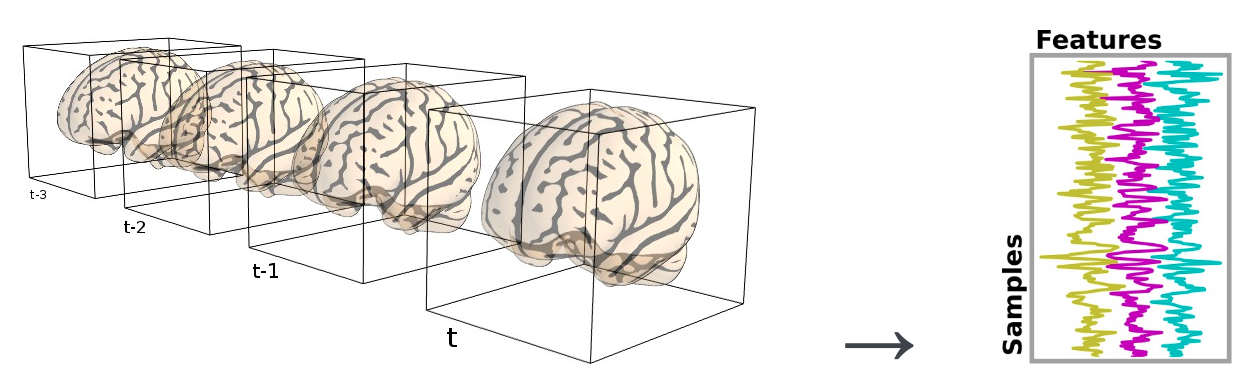

In [9]:
from IPython.display import Image
Image(filename='masker.png') 

*copyright - Image taken from the nilearn documentation.*

More information on maskers can be found in the <a href="https://nilearn.github.io/manipulating_images/masker_objects.html">nilearn online documentation</a>.

In [10]:
from nilearn.input_data import NiftiLabelsMasker

# Use NiftiLabelsMasker to extract signals from regions
masker = NiftiLabelsMasker(labels_img=maps, 
                           standardize=True) # Standardize the signals
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, 
                                            confounds=confounds))
time_series = np.array(time_series)
time_series.shape

(10, 168, 124)

We have **124** standardized time series of length **168** per subject (**10** subjects were loaded). 

We can plot them if needed:

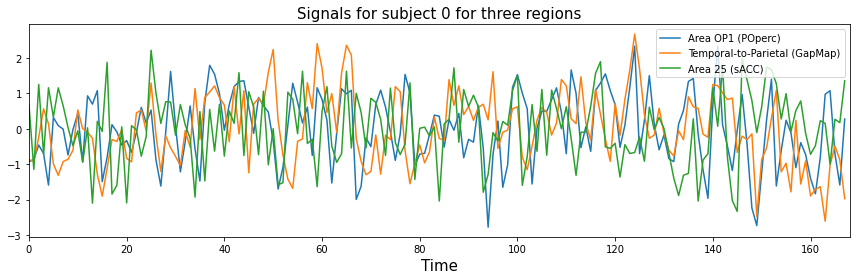

In [11]:
import matplotlib.pyplot as plt

subject_id = 0
fig = plt.figure(figsize=(12,4))
for i in [0,1,2]:
    plt.plot(time_series[subject_id, :, i], 
             label=labels[i])
plt.legend()
plt.xlim((0, 168))
plt.xlabel("Time", fontsize=15)
plt.title(f"Signals for subject {subject_id} for three regions", fontsize=15)
plt.tight_layout()

<a id="Step4"></a>

## Step 4: Use Nilearn to compute a connectivity matrix

Here we compute the correlation between these time series:

In [12]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(time_series)
assert correlation_matrix.shape == (10, 124, 124)

In order to visualize this matrix, we take the mean accross subject:

In [13]:
mean_correlation_matrix = correlation_measure.mean_
assert mean_correlation_matrix.shape == (124, 124)

<a id="Step5"></a>

## Step 5: Use nilearn to visualize the connectivity

We can use **Nilearn** to visualize the connectivity, either as a matrix or as a graph:

### As a matrix

We can plot the matrix with the region names:

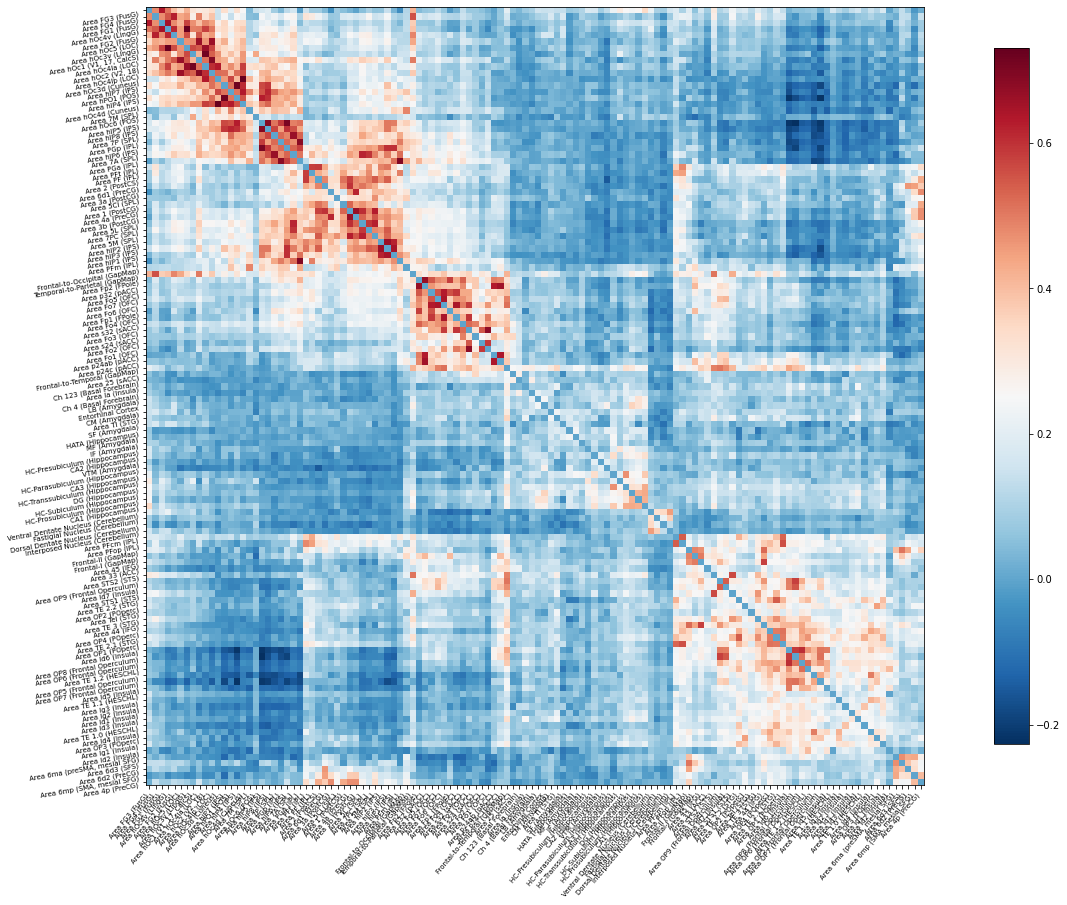

In [14]:
from nilearn.plotting import plot_matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(mean_correlation_matrix, 0)
# matrices are ordered for block-like representation
plot_matrix(mean_correlation_matrix, 
            figure=(16, 16), 
            labels=labels, 
            reorder=True)

### As a graph

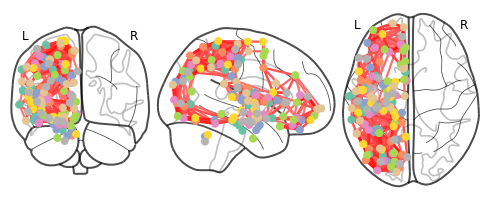

In [15]:
from nilearn.plotting import plot_connectome, find_parcellation_cut_coords

# grab center coordinates for atlas labels
coordinates = find_parcellation_cut_coords(labels_img=maps)
# plot connectome with 95% edge strength in the connectivity
plot_connectome(mean_correlation_matrix, 
                coordinates,
                edge_threshold="95%")

<a id="Step6"></a>

## Step 6: Upload the results back to ebrains

**TODOS:**

- Decide on a representation of the connectivity results
- Find how these results could be uploaded